# **Import Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder


In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

## **DATA**

### Binary Prediction of Poisonous Mushrooms | [kaggle](https://www.kaggle.com/competitions/playground-series-s4e8/overview) |



*Playground Series - Season 4, Episode 8*

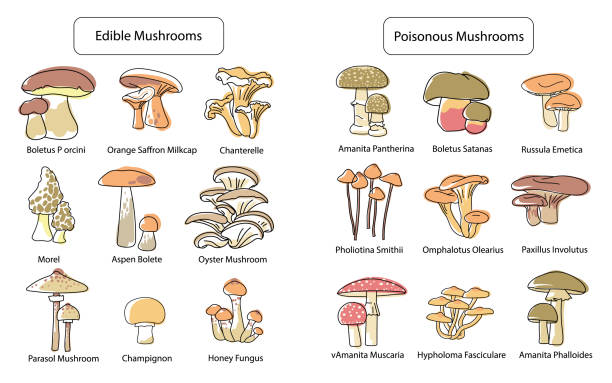

The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Note:** Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

#### Files
* **train.csv** - the training dataset; class is the binary target (either e or p)
* **test.csv** - the test dataset; your objective is to predict target class for each row
* **sample_submission.csv** - a sample submission file in the correct format

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/data

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/FANSHAWE/INFO-6147-(01)-24F/playground-series-s4e8.zip" "/content/data/"  # First way
# !cp /content/drive/MyDrive/Colab\ Notebooks/FANSHAWE/INFO-6147-\(01\)-24F/playground-series-s4e8.zip /content/data/   # Second way

In [ ]:
!unzip /content/data/playground-series-s4e8.zip -d /content/data

Archive:  /content/data/playground-series-s4e8.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [ ]:
!rm /content/data/playground-series-s4e8.zip

## **Load Data**

### Load the Train set and visualization

In [ ]:
# Load the train dataset
df_train = pd.read_csv('data/train.csv')
df_train = df_train.drop(columns=['id'])
df_train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,e,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,p,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,e,9.45,p,i,n,t,e,NaN,p,9.13,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [ ]:
df_train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
class,3116945,2,p,1705396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap-diameter,3116941.0,NaN,NaN,NaN,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
cap-shape,3116905,74,x,1436026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap-surface,2445922,83,t,460777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap-color,3116933,78,n,1359542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
does-bruise-or-bleed,3116937,26,f,2569743,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-attachment,2593009,78,a,646034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-spacing,1858510,48,c,1331054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-color,3116888,63,w,931538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stem-height,3116945.0,NaN,NaN,NaN,6.348333,2.699755,0.0,4.67,5.88,7.41,88.72


In [ ]:
df_train.isna().sum()

,0
class,0
cap-diameter,4
cap-shape,40
cap-surface,671023
cap-color,12
does-bruise-or-bleed,8
gill-attachment,523936
gill-spacing,1258435
gill-color,57
stem-height,0


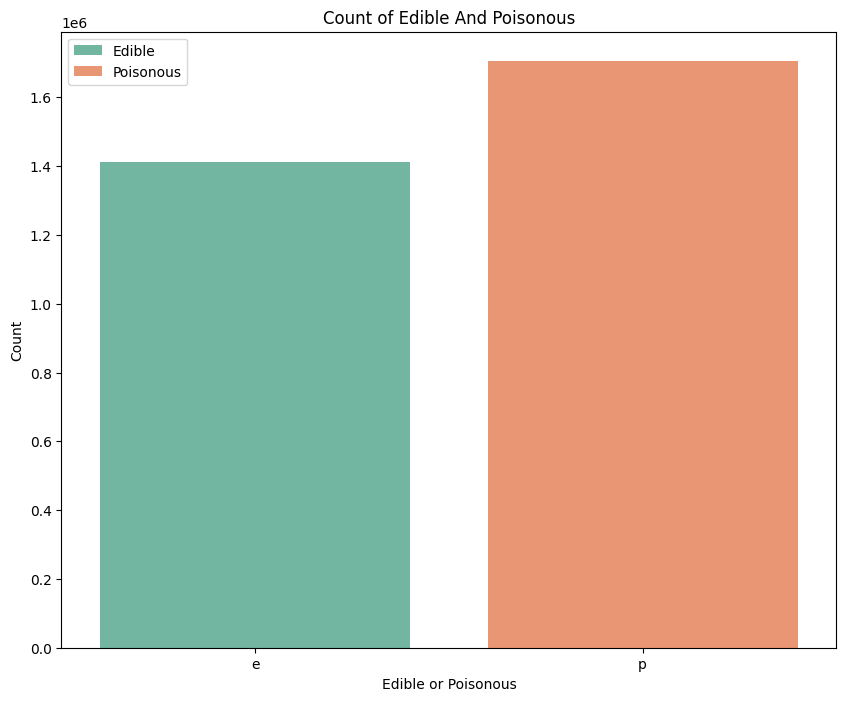

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df_train, x='class', hue='class', palette='Set2', dodge=False)
plt.title('Count of Edible And Poisonous')
plt.xlabel('Edible or Poisonous')
plt.ylabel('Count')
plt.legend(['Edible', 'Poisonous'])
plt.show()

In [ ]:
df_train['class'].value_counts()

,count
class,
p,1705396
e,1411549


In [ ]:
num_samples, num_features = df_train.shape
num_features -= 1    # remove label column
num_classes = len(np.unique(df_train['class']))
num_samples, num_features, num_classes

(3116945, 20, 2)

In [ ]:
# Map the target column
df_train['class'] = df_train['class'].map({'e': 0, 'p': 1})
# df_train_cla = df_train['class']

### Load the Test set

In [ ]:
# Load the test dataset
df_test = pd.read_csv('data/test.csv')
df_test_id = df_test['id']
df_test = df_test.drop(columns=['id'])
df_test

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
1,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,0.88,x,g,w,f,a,d,w,2.67,1.35,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
2077960,3.12,x,s,w,f,d,c,w,2.69,7.38,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
2077961,5.73,x,e,e,f,a,NaN,w,6.16,9.74,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5.03,b,g,n,f,a,d,g,6.00,3.46,NaN,s,g,NaN,NaN,f,f,NaN,d,a


In [ ]:
df_train.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [ ]:
df_test.columns

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [ ]:
df_test.isnull().sum()

,0
cap-diameter,7
cap-shape,31
cap-surface,446904
cap-color,13
does-bruise-or-bleed,10
gill-attachment,349821
gill-spacing,839595
gill-color,49
stem-height,1
stem-width,0


## **Preprocessing**

### Handle NaN values

In [ ]:
df_train.isna().mean() * 100

,0
class,0.000000
cap-diameter,0.000128
cap-shape,0.001283
cap-surface,21.528227
cap-color,0.000385
does-bruise-or-bleed,0.000257
gill-attachment,16.809280
gill-spacing,40.373988
gill-color,0.001829
stem-height,0.000000


In [ ]:
df_test.isna().mean() * 100

,0
cap-diameter,0.000337
cap-shape,0.001492
cap-surface,21.506821
cap-color,0.000626
does-bruise-or-bleed,0.000481
gill-attachment,16.834796
gill-spacing,40.404694
gill-color,0.002358
stem-height,0.000048
stem-width,0.000000


In [ ]:
# Check and drop columns with too many missing values
missing_threshold = 0.95

# For Train part
high_missing_columns_1 = df_train.columns[df_train.isna().mean() > missing_threshold]
print(high_missing_columns_1)

df_train = df_train.drop(columns=high_missing_columns_1)

# For Test part
high_missing_columns_2 = df_test.columns[df_test.isna().mean() > missing_threshold]
print(high_missing_columns_2)

df_test = df_test.drop(columns=high_missing_columns_2)

df_train.head()

Index([], dtype='object')
Index([], dtype='object')


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,0,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,0,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,0,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
counts=[]
for column in df_train.columns:
  if df_train[column].dtype == 'object':
    letters = df_train[column].unique()
    counts = df_train[column].value_counts()
    print(f"'{column}' : {letters} unique categories & value counts : {counts}")

'cap-shape' : ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06'] unique categories & value counts : cap-shape
x        1436026
f         676238
s         365146
b         318646
o         108835
          ...   
12.62          1
5.15           1
19.04          1
49.21          1
19.06          1
Name: count, Length: 74, dtype: int64
'cap-surface' : ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39'

In [ ]:
for col in df_train:
  if df_train[col].dtype == 'object':
    letters = df_train[col].nunique()
    print(f"'{col}' : {letters} unique categories.")

'cap-shape' : 74 unique categories.
'cap-surface' : 83 unique categories.
'cap-color' : 78 unique categories.
'does-bruise-or-bleed' : 26 unique categories.
'gill-attachment' : 78 unique categories.
'gill-spacing' : 48 unique categories.
'gill-color' : 63 unique categories.
'stem-root' : 38 unique categories.
'stem-surface' : 60 unique categories.
'stem-color' : 59 unique categories.
'veil-type' : 22 unique categories.
'veil-color' : 24 unique categories.
'has-ring' : 23 unique categories.
'ring-type' : 40 unique categories.
'spore-print-color' : 32 unique categories.
'habitat' : 52 unique categories.
'season' : 4 unique categories.


In [ ]:
for column in df_train:
  if df_train[column].dtype == 'object':
    print(column ,': ' ,df_train[column].unique())

cap-shape :  ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']
cap-surface :  ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.73'
 'is None' '24.38' '2.81' '0.88' '2.11' '2.79' 'ring-type'
 'does-bruise-or-bleed' '4.93' 'spore-print-color' 'spore-color' '2.92'
 '2.51' '7.

### First Way: Impute missing values

In [ ]:
# Impute categorical missing values for the Train part
mode_values_1 = df_train.mode()
mode_values_1 = mode_values_1.loc[0].to_dict()

# Impute categorical missing values for the Test part
mode_values_2 = df_test.mode()
mode_values_2 = mode_values_2.loc[0].to_dict()

mode_values_1['cap-diameter'], mode_values_1['cap-shape']

(1.49, 'x')

In [ ]:
# Impute numerical missing values for the Train part
median_values_1 = df_train.median(numeric_only=True).to_dict()

# Impute numerical missing values for the Test part
median_values_2 = df_test.median(numeric_only=True).to_dict()

median_values_1

{'cap-diameter': 5.75, 'stem-height': 5.88, 'stem-width': 9.65}

In [ ]:
# Impute for all missing values for the Train part
for column in df_train.columns:

  if df_train[column].isna().any():

    if df_train[column].dtype == 'object':
      df_train[column] = df_train[column].fillna(mode_values_1[column])

    else:
      df_train[column] = df_train[column].fillna(median_values_1[column])


df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,b,s,w,u,w,f,f,k,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,b,y,o,u,w,t,z,k,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,b,s,n,u,w,f,f,k,l,w
3,e,3.88,f,y,g,f,s,c,g,4.16,...,b,s,w,u,w,f,f,k,d,u
4,e,5.85,x,l,w,f,d,c,w,3.37,...,b,s,w,u,w,f,f,k,g,a


In [ ]:
# Impute for all missing values for the Test part
for column in df_test.columns:

  if df_test[column].isna().any():

    if df_test[column].dtype == 'object':
      df_test[column] = df_test[column].fillna(mode_values_2[column])

    else:
      df_test[column] = df_test[column].fillna(median_values_2[column])

df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,x,t,n,t,a,c,w,11.13,17.12,b,s,w,u,w,t,g,k,d,a
1,6.90,o,t,o,f,a,c,y,1.27,10.75,b,s,n,u,w,f,f,k,d,a
2,2.00,b,g,n,f,a,c,n,6.18,3.14,b,s,n,u,w,f,f,k,d,s
3,3.47,x,t,n,f,s,c,n,4.98,8.51,b,s,w,u,n,t,z,k,d,u
4,6.17,x,h,y,f,p,c,y,6.73,13.70,b,s,y,u,y,t,f,k,d,u


In [ ]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())


0
0


### Second Way: Impute missing values with **SimpleImputer()**

**I used second way.**

In [ ]:
from sklearn.impute import SimpleImputer

# Function to clean missing data
def cleaning_data(df, strategy='mean'):
    """Clean missing values in a DataFrame using the specified strategy."""
    df = df.copy()  # Avoid modifying the original DataFrame
    imputer = SimpleImputer(strategy=strategy)
    transformed = imputer.fit_transform(df)
    return pd.DataFrame(transformed, columns=df.columns)

In [ ]:
# Separate numerical and categorical columns
num_columns = df_train.select_dtypes(exclude='object').columns
cat_columns = df_train.select_dtypes(include='object').columns

# Clean data for numerical and categorical columns
df_train[num_columns] = cleaning_data(df_train[num_columns], strategy='median')

# Ensure categorical columns are treated as strings for imputation
df_train[cat_columns] = cleaning_data(df_train[cat_columns], strategy='most_frequent')

# Concatenate numerical and categorical columns
df_train = pd.concat([df_train[num_columns], df_train[cat_columns]], axis=1)

# Verify the shape of the combined DataFrame
print(df_train.shape)

# Optionally, preview the concatenated DataFrame
df_train.head()


(3116945, 21)


,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,4.51,15.39,f,s,u,f,a,c,...,b,s,w,u,w,f,f,k,d,a
1,1.0,4.51,4.79,6.48,x,h,o,f,a,c,...,b,y,o,u,w,t,z,k,d,w
2,0.0,6.94,6.85,9.93,f,s,b,f,x,c,...,b,s,n,u,w,f,f,k,l,w
3,0.0,3.88,4.16,6.53,f,y,g,f,s,c,...,b,s,w,u,w,f,f,k,d,u
4,0.0,5.85,3.37,8.36,x,l,w,f,d,c,...,b,s,w,u,w,f,f,k,g,a


In [ ]:
# Verify missing values are handled
print(df_train.isnull().sum())

class                   0
cap-diameter            0
stem-height             0
stem-width              0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


In [ ]:
# Separate numerical and categorical columns
num_columns_te = df_test.select_dtypes(exclude='object').columns
cat_columns_te = df_test.select_dtypes(include='object').columns

# Clean data for numerical and categorical columns
df_test[num_columns_te] = cleaning_data(df_test[num_columns_te], strategy='median')

# Ensure categorical columns are treated as strings for imputation
df_test[cat_columns_te] = cleaning_data(df_test[cat_columns_te], strategy='most_frequent')

# Concatenate numerical and categorical columns
df_test = pd.concat([df_test[num_columns_te], df_test[cat_columns_te]], axis=1)

# Verify the shape of the combined DataFrame
print(df_test.shape)

# Optionally, preview the concatenated DataFrame
df_test.head()

(2077964, 20)


,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,11.13,17.12,x,t,n,t,a,c,w,b,s,w,u,w,t,g,k,d,a
1,6.90,1.27,10.75,o,t,o,f,a,c,y,b,s,n,u,w,f,f,k,d,a
2,2.00,6.18,3.14,b,g,n,f,a,c,n,b,s,n,u,w,f,f,k,d,s
3,3.47,4.98,8.51,x,t,n,f,s,c,n,b,s,w,u,n,t,z,k,d,u
4,6.17,6.73,13.70,x,h,y,f,p,c,y,b,s,y,u,y,t,f,k,d,u


In [ ]:
# Verify missing values are handled
print(df_test.isnull().sum())

cap-diameter            0
stem-height             0
stem-width              0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


In [ ]:
threshold = 70  # 70 ~ 100
def low_freq_catogories(df, threshold=threshold):
    for column in df.columns:
      if df_train[column].dtype == 'object':
        counts = df[column].value_counts()
        others = counts[counts <= threshold].index
        df[column] = df[column].apply(lambda x: "other" if x in others else x)
    return df


df_train=low_freq_catogories(df_train)
df_test=low_freq_catogories(df_test)

In [ ]:
for col in df_train:
  if df_train[col].dtype == 'object':
    letters = df_train[col].nunique()
    print(f"'{col}' : {letters} unique categories.")

'cap-shape' : 8 unique categories.
'cap-surface' : 14 unique categories.
'cap-color' : 13 unique categories.
'does-bruise-or-bleed' : 3 unique categories.
'gill-attachment' : 9 unique categories.
'gill-spacing' : 4 unique categories.
'gill-color' : 13 unique categories.
'stem-root' : 6 unique categories.
'stem-surface' : 9 unique categories.
'stem-color' : 14 unique categories.
'veil-type' : 2 unique categories.
'veil-color' : 7 unique categories.
'has-ring' : 3 unique categories.
'ring-type' : 10 unique categories.
'spore-print-color' : 8 unique categories.
'habitat' : 9 unique categories.
'season' : 4 unique categories.


In [ ]:
for column in df_train:
  if df_train[column].dtype == 'object':
    print(column ,': ' ,df_train[column].unique())

cap-shape :  ['f' 'x' 'p' 'b' 'o' 'c' 's' 'other']
cap-surface :  ['s' 'h' 'y' 'l' 't' 'e' 'g' 'd' 'i' 'w' 'k' 'other' 'f' 'n']
cap-color :  ['u' 'o' 'b' 'g' 'w' 'n' 'e' 'y' 'r' 'p' 'k' 'l' 'other']
does-bruise-or-bleed :  ['f' 't' 'other']
gill-attachment :  ['a' 'x' 's' 'd' 'e' 'f' 'p' 'other' 'c']
gill-spacing :  ['c' 'd' 'f' 'other']
gill-color :  ['w' 'n' 'g' 'k' 'y' 'f' 'p' 'o' 'b' 'u' 'e' 'r' 'other']
stem-root :  ['b' 'c' 'r' 's' 'f' 'other']
stem-surface :  ['s' 'y' 't' 'g' 'h' 'k' 'i' 'f' 'other']
stem-color :  ['w' 'o' 'n' 'y' 'e' 'u' 'p' 'f' 'g' 'r' 'k' 'l' 'b' 'other']
veil-type :  ['u' 'other']
veil-color :  ['w' 'n' 'k' 'y' 'e' 'u' 'other']
has-ring :  ['f' 't' 'other']
ring-type :  ['f' 'z' 'e' 'p' 'l' 'g' 'r' 'm' 'other' 't']
spore-print-color :  ['k' 'w' 'p' 'n' 'r' 'u' 'g' 'other']
habitat :  ['d' 'l' 'g' 'h' 'p' 'm' 'u' 'w' 'other']
season :  ['a' 'w' 'u' 's']


## Encoding

### First way, using the ***OrdinalEncoder()*** method

In [ ]:
df_train

,cap-diameter,stem-height,stem-width,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.80,4.51,15.39,0,f,s,u,f,a,c,...,b,s,w,u,w,f,f,k,d,a
1,4.51,4.79,6.48,1,x,h,o,f,a,c,...,b,y,o,u,w,t,z,k,d,w
2,6.94,6.85,9.93,0,f,s,b,f,x,c,...,b,s,n,u,w,f,f,k,l,w
3,3.88,4.16,6.53,0,f,y,g,f,s,c,...,b,s,w,u,w,f,f,k,d,u
4,5.85,3.37,8.36,0,x,l,w,f,d,c,...,b,s,w,u,w,f,f,k,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,9.29,12.14,18.81,0,f,t,n,t,a,c,...,b,s,w,u,w,t,g,k,d,u
3116941,10.88,6.65,26.97,0,s,t,w,t,d,c,...,b,s,w,u,w,f,f,k,d,u
3116942,7.82,9.51,11.06,1,x,e,e,f,a,c,...,b,s,y,u,w,t,z,k,d,a
3116943,9.45,9.13,17.77,0,p,i,n,t,e,c,...,b,y,w,u,w,t,p,k,d,u


In [ ]:
# Encode categorical variables
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

cat_cols_train = df_train.select_dtypes(include=['object']).columns
print(cat_cols_train)
cat_cols_test = df_test.select_dtypes(include=['object']).columns


df_train[cat_cols_train] = ordinal_encoder.fit_transform(df_train[cat_cols_train].astype(str))
df_test[cat_cols_test] = ordinal_encoder.fit_transform(df_test[cat_cols_test].astype(str))

df_train.head()

Index([], dtype='object')


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,4.51,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
1,1.0,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,4.79,...,15.0,58.0,47.0,19.0,21.0,18.0,39.0,17.0,25.0,3.0
2,0.0,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,6.85,...,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,36.0,3.0
3,0.0,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,4.16,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0
4,0.0,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,3.37,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,29.0,0.0


In [ ]:
df_train['cap-surface'].value_counts()

,count
cap-surface,
76.0,1131800
72.0,384970
81.0,327826
56.0,284460
55.0,263729
...,...
5.0,1
57.0,1
9.0,1


### Second way, using ***One-Hot Encoding***

In [ ]:
df_train

,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,4.51,15.39,f,s,u,f,a,c,...,b,s,w,u,w,f,f,k,d,a
1,1.0,4.51,4.79,6.48,x,h,o,f,a,c,...,b,y,o,u,w,t,z,k,d,w
2,0.0,6.94,6.85,9.93,f,s,b,f,x,c,...,b,s,n,u,w,f,f,k,l,w
3,0.0,3.88,4.16,6.53,f,y,g,f,s,c,...,b,s,w,u,w,f,f,k,d,u
4,0.0,5.85,3.37,8.36,x,l,w,f,d,c,...,b,s,w,u,w,f,f,k,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0.0,9.29,12.14,18.81,f,t,n,t,a,c,...,b,s,w,u,w,t,g,k,d,u
3116941,0.0,10.88,6.65,26.97,s,t,w,t,d,c,...,b,s,w,u,w,f,f,k,d,u
3116942,1.0,7.82,9.51,11.06,x,e,e,f,a,c,...,b,s,y,u,w,t,z,k,d,a
3116943,0.0,9.45,9.13,17.77,p,i,n,t,e,c,...,b,y,w,u,w,t,p,k,d,u


In [ ]:
df_train['cap-shape'].value_counts()

,count
cap-shape,
x,1436066
f,676238
s,365146
b,318646
o,108835
p,106967
c,104520
other,527


#### Convert Categorical Values to Numerical

#### a. One-Hot Encoding
* Suitable for categorical features with no ordinal relationship.
* Creates binary columns for each unique category in a feature.

In [ ]:
# One-Hot Encoding
df_train_encoded = pd.get_dummies(df_train, columns=cat_columns, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=cat_columns_te, drop_first=True)


In [ ]:
df_train_encoded.shape, df_test_encoded.shape

((3116945, 123), (2077964, 118))

##### Why Is There a Column Mismatch?
One-hot encoding creates a separate column for each unique category in the categorical features. If a category appears in `df_train` but not in `df_test`, the corresponding column is missing in `df_test`.

In [ ]:
# Align df_test_encoded with df_train_encoded
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)


In [ ]:
df_train_encoded.shape, df_test_encoded.shape

((3116945, 123), (2077964, 123))

In [ ]:
# Code to Check Column Names
# Compare column names
train_columns = df_train_encoded.columns
test_columns = df_test_encoded.columns

if train_columns.equals(test_columns):
    print("Column names in both datasets are identical.")
else:
    print("Column names differ between the datasets.")
    # Optionally print differences
    print("Columns in train but not in test:", set(train_columns) - set(test_columns))
    print("Columns in test but not in train:", set(test_columns) - set(train_columns))


Column names in both datasets are identical.


#### b. Label Encoding
* Suitable if categorical values have an inherent order or ranking.
* Converts categories into integer values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in cat_columns:
    df_train[col] = encoder.fit_transform(df_train[col])
    if col in df_test.columns:  # Ensure column exists in df_test
        df_test[col] = encoder.transform(df_test[col])


In [ ]:
df_train

,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,4.51,15.39,2,10,10,0,0,0,...,0,6,12,1,5,0,1,1,0,0
1,1.0,4.51,4.79,6.48,7,4,6,0,0,0,...,0,8,7,1,5,2,9,1,0,3
2,0.0,6.94,6.85,9.93,2,10,0,0,8,0,...,0,6,6,1,5,0,1,1,3,3
3,0.0,3.88,4.16,6.53,2,13,2,0,7,0,...,0,6,12,1,5,0,1,1,0,2
4,0.0,5.85,3.37,8.36,7,7,11,0,2,0,...,0,6,12,1,5,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0.0,9.29,12.14,18.81,2,11,5,2,0,0,...,0,6,12,1,5,2,2,1,0,2
3116941,0.0,10.88,6.65,26.97,6,11,11,2,2,0,...,0,6,12,1,5,0,1,1,0,2
3116942,1.0,7.82,9.51,11.06,7,1,1,0,0,0,...,0,6,13,1,5,2,9,1,0,0
3116943,0.0,9.45,9.13,17.77,5,5,5,2,3,0,...,0,8,12,1,5,2,6,1,0,2


In [ ]:
df_test

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,11.13,17.12,7,11,5,2,0,0,11,0,6,12,1,5,2,2,1,0,0
1,6.90,1.27,10.75,3,11,6,0,0,0,12,0,6,6,1,5,0,1,1,0,0
2,2.00,6.18,3.14,0,3,5,0,0,0,5,0,6,6,1,5,0,1,1,0,1
3,3.47,4.98,8.51,7,11,5,0,7,0,5,0,6,12,1,2,2,9,1,0,2
4,6.17,6.73,13.70,7,4,12,0,6,0,12,0,6,13,1,6,2,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,0.88,2.67,1.35,7,3,11,0,0,1,11,0,6,1,1,5,0,1,1,0,2
2077960,3.12,2.69,7.38,7,10,11,0,2,0,11,0,6,12,1,5,0,1,1,1,0
2077961,5.73,6.16,9.74,7,1,1,0,0,0,11,0,6,13,1,5,2,9,1,0,0
2077962,5.03,6.00,3.46,0,3,5,0,0,1,3,0,6,3,1,5,0,1,1,0,0


#### Scaling Numerical Feature (Normalization)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train_encoded[num_columns] = scaler.fit_transform(df_train_encoded[num_columns])
df_test_encoded[num_columns] = scaler.transform(df_test_encoded[num_columns])


In [ ]:
df_train_encoded

,class,cap-diameter,stem-height,stem-width,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_other,cap-shape_p,cap-shape_s,...,habitat_h,habitat_l,habitat_m,habitat_other,habitat_p,habitat_u,habitat_w,season_s,season_u,season_w
0,-1.099169,0.534605,-0.680926,0.523282,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.909778,-0.386405,-0.577213,-0.577333,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-1.099169,0.135286,0.185819,-0.151169,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,-1.099169,-0.521659,-0.810568,-0.571157,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,-1.099169,-0.098724,-1.103187,-0.345105,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,-1.099169,0.639802,2.145257,0.945740,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3116941,-1.099169,0.981156,0.111739,1.953710,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3116942,0.909778,0.324211,1.171094,-0.011585,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3116943,-1.099169,0.674152,1.030341,0.817273,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


### Third way

**I used the third way.**

### Use **Embedding Layers**

In [ ]:
df_train

,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,4.51,15.39,f,s,u,f,a,c,...,b,s,w,u,w,f,f,k,d,a
1,1.0,4.51,4.79,6.48,x,h,o,f,a,c,...,b,y,o,u,w,t,z,k,d,w
2,0.0,6.94,6.85,9.93,f,s,b,f,x,c,...,b,s,n,u,w,f,f,k,l,w
3,0.0,3.88,4.16,6.53,f,y,g,f,s,c,...,b,s,w,u,w,f,f,k,d,u
4,0.0,5.85,3.37,8.36,x,l,w,f,d,c,...,b,s,w,u,w,f,f,k,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0.0,9.29,12.14,18.81,f,t,n,t,a,c,...,b,s,w,u,w,t,g,k,d,u
3116941,0.0,10.88,6.65,26.97,s,t,w,t,d,c,...,b,s,w,u,w,f,f,k,d,u
3116942,1.0,7.82,9.51,11.06,x,e,e,f,a,c,...,b,s,y,u,w,t,z,k,d,a
3116943,0.0,9.45,9.13,17.77,p,i,n,t,e,c,...,b,y,w,u,w,t,p,k,d,u


In [ ]:
# Columns that need to be converted
cat_columns = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
               'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
               'stem-surface', 'stem-color', 'veil-type', 'veil-color',
               'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

# Step 1: Create mappings for each categorical column
category_mappings = {}  # To store mappings for each column

for col in cat_columns:
    # Create a mapping for the column
    unique_categories = pd.concat([df_train[col], df_test[col]]).unique()
    category_mappings[col] = {cat: idx for idx, cat in enumerate(unique_categories)}

# Step 2: Apply the mappings to both train and test datasets
def map_categorical_columns(df, category_mappings):
    for col, mapping in category_mappings.items():
        df[col] = df[col].map(mapping)
    return df

df_train = map_categorical_columns(df_train, category_mappings)
df_test = map_categorical_columns(df_test, category_mappings)


In [ ]:
df_train

,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,8.80,4.51,15.39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,4.51,4.79,6.48,1,1,1,0,0,0,...,0,1,1,0,0,1,1,0,0,1
2,0.0,6.94,6.85,9.93,0,0,2,0,1,0,...,0,0,2,0,0,0,0,0,1,1
3,0.0,3.88,4.16,6.53,0,2,3,0,2,0,...,0,0,0,0,0,0,0,0,0,2
4,0.0,5.85,3.37,8.36,1,3,4,0,3,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0.0,9.29,12.14,18.81,0,4,5,1,0,0,...,0,0,0,0,0,1,5,0,0,2
3116941,0.0,10.88,6.65,26.97,6,4,4,1,3,0,...,0,0,0,0,0,0,0,0,0,2
3116942,1.0,7.82,9.51,11.06,1,5,6,0,0,0,...,0,0,3,0,0,1,1,0,0,0
3116943,0.0,9.45,9.13,17.77,2,8,5,1,4,0,...,0,1,0,0,0,1,3,0,0,2


In [ ]:
df_test

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,11.13,17.12,1,4,5,1,0,0,0,0,0,0,0,0,1,5,0,0,0
1,6.90,1.27,10.75,4,4,1,0,0,0,4,0,0,2,0,0,0,0,0,0,0
2,2.00,6.18,3.14,3,6,5,0,0,0,1,0,0,2,0,0,0,0,0,0,3
3,3.47,4.98,8.51,1,4,5,0,2,0,1,0,0,0,0,1,1,1,0,0,2
4,6.17,6.73,13.70,1,1,7,0,6,0,4,0,0,3,0,3,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,0.88,2.67,1.35,1,6,4,0,0,1,0,0,0,4,0,0,0,0,0,0,2
2077960,3.12,2.69,7.38,1,0,4,0,3,0,0,0,0,0,0,0,0,0,0,2,0
2077961,5.73,6.16,9.74,1,5,6,0,0,0,0,0,0,3,0,0,1,1,0,0,0
2077962,5.03,6.00,3.46,3,6,5,0,0,1,2,0,0,8,0,0,0,0,0,0,0


#### Scaling Numerical Feature (Normalization)

In [ ]:
from sklearn.preprocessing import StandardScaler

num_columns = ['cap-diameter', 'stem-height', 'stem-width']

scaler = StandardScaler()
df_train[num_columns] = scaler.fit_transform(df_train[num_columns])
df_test[num_columns] = scaler.transform(df_test[num_columns])


In [ ]:
df_train

,class,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0,0.534605,-0.680926,0.523282,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,-0.386405,-0.577213,-0.577333,1,1,1,0,0,0,...,0,1,1,0,0,1,1,0,0,1
2,0.0,0.135286,0.185819,-0.151169,0,0,2,0,1,0,...,0,0,2,0,0,0,0,0,1,1
3,0.0,-0.521659,-0.810568,-0.571157,0,2,3,0,2,0,...,0,0,0,0,0,0,0,0,0,2
4,0.0,-0.098724,-1.103187,-0.345105,1,3,4,0,3,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0.0,0.639802,2.145257,0.945740,0,4,5,1,0,0,...,0,0,0,0,0,1,5,0,0,2
3116941,0.0,0.981156,0.111739,1.953710,6,4,4,1,3,0,...,0,0,0,0,0,0,0,0,0,2
3116942,1.0,0.324211,1.171094,-0.011585,1,5,6,0,0,0,...,0,0,3,0,0,1,1,0,0,0
3116943,0.0,0.674152,1.030341,0.817273,2,8,5,1,4,0,...,0,1,0,0,0,1,3,0,0,2


In [ ]:
df_test

,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.500255,1.771149,0.736981,1,4,5,1,0,0,0,0,0,0,0,0,1,5,0,0,0
1,0.126699,-1.881035,-0.049878,4,4,1,0,0,0,4,0,0,2,0,0,0,0,0,0,0
2,-0.925272,-0.062351,-0.989909,3,6,5,0,0,0,1,0,0,2,0,0,0,0,0,0,3
3,-0.609681,-0.506836,-0.326576,1,4,5,0,2,0,1,0,0,0,0,1,1,1,0,0,2
4,-0.030024,0.141371,0.314523,1,1,7,0,6,0,4,0,0,3,0,3,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,-1.165722,-1.362470,-1.211020,1,6,4,0,0,1,0,0,0,4,0,0,0,0,0,0,2
2077960,-0.684821,-1.355062,-0.466160,1,0,4,0,3,0,0,0,0,0,0,0,0,0,0,2,0
2077961,-0.124486,-0.069759,-0.174639,1,5,6,0,0,0,0,0,0,3,0,0,1,1,0,0,0
2077962,-0.274768,-0.129024,-0.950381,3,6,5,0,0,1,2,0,0,8,0,0,0,0,0,0,0


### Prepare Data for PyTorch

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 float64
 1   cap-diameter          float64
 2   stem-height           float64
 3   stem-width            float64
 4   cap-shape             int64  
 5   cap-surface           int64  
 6   cap-color             int64  
 7   does-bruise-or-bleed  int64  
 8   gill-attachment       int64  
 9   gill-spacing          int64  
 10  gill-color            int64  
 11  stem-root             int64  
 12  stem-surface          int64  
 13  stem-color            int64  
 14  veil-type             int64  
 15  veil-color            int64  
 16  has-ring              int64  
 17  ring-type             int64  
 18  spore-print-color     int64  
 19  habitat               int64  
 20  season                int64  
dtypes: float64(4), int64(17)
memory usage: 499.4 MB


### Split the Train Data to train set and val set

In [ ]:
df1 = df_train.copy()
df2 = df_test.copy()
# df_train = df1.copy()

In [ ]:
# Create Train and Validation Splits
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=10, stratify=df_train['class'])

# Numerical features
X_train_num = df_train[num_columns].values
X_valid_num = df_valid[num_columns].values
X_test_num = df_test[num_columns].values

# Categorical features
X_train_cat = df_train[cat_columns].values
X_valid_cat = df_valid[cat_columns].values
X_test_cat = df_test[cat_columns].values

# Targets
y_train = df_train['class'].values
y_valid = df_valid['class'].values

len(df_train), len(df_valid)

(2493556, 623389)

In [ ]:
X_train_num.shape, X_valid_num.shape, X_test_num.shape, X_train_cat.shape, X_valid_cat.shape, X_test_cat.shape, y_train.shape, y_valid.shape

((2493556, 3),
 (623389, 3),
 (2077964, 3),
 (2493556, 17),
 (623389, 17),
 (2077964, 17),
 (2493556,),
 (623389,))

In [ ]:
y_train

array([1., 0., 0., ..., 1., 1., 1.])

In [ ]:
# Verify the Shapes of the Data
print("X_train_num shape:", X_train_num.shape)
print("X_train_cat shape:", X_train_cat.shape)
print("y_train shape:", y_train.shape)


X_train_num shape: (2493556, 3)
X_train_cat shape: (2493556, 17)
y_train shape: (2493556,)


In [ ]:
# Check the Data Types
print("X_train_num sample:", X_train_num[0])
print("X_train_cat sample:", X_train_cat[0])
s

X_train_num sample: [-0.64617753 -0.9587292  -0.94543981]
X_train_cat sample: [5 4 0 0 0 0 1 0 6 5 0 0 0 0 0 0 0]


### Note:
We must ensure **y_train** and **y_valid** are **LongTensor** if we use them in a **classification** context with **PyTorch**, as **classification loss functions expect integer labels (not floating-point)**. We can change their type as follows:


#### Important Note:
According to use **SimpleImputer()**, the **label was converted** from **int** to **float**.
There are some ways to ensure y_train and y_valid are Integer.

**First:**

use the snippet below befor convert to tensor.

```
y_train = y_train.astype(int)  # Ensure integer labels
print(np.unique(y_train))      # Check unique values
```
and
```
y_train = torch.tensor(y_train, dtype=torch.int32).view(-1).to(device)  # Binary target
y_valid = torch.tensor(y_valid, dtype=torch.long).view(-1).to(device)   # .int32 or .long
```

**Second:**

If we use the snippet below:

```
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)  # Binary target
y_valid = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1).to(device)
```
We have to use:

```
# Convert y_train to integers and flatten if necessary
y_train = y_train.to(torch.int).view(-1)  # Ensure it is integer & 1D


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.cpu().numpy()),  # Convert tensor to NumPy array for sklearn
    y=y_train.cpu().numpy().flatten()  # Convert tensor to NumPy array for sklearn & Flatten the array
)
```
**Third:**

Use:

```
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1).to(device)  # Binary target
y_valid = torch.tensor(y_valid, dtype=torch.float32).reshape(-1).to(device)

```
or use:

```
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)  # Binary target
y_valid = torch.tensor(y_valid, dtype=torch.float32).view(-1).to(device)

```
The **reshape(-1)** function is equivalent to **view(-1)** in this context.

And after use:

```
# Convert y_train to integers and flatten if necessary
y_train = y_train.to(torch.int)  # Ensure it is integer

# Calculate weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.cpu().numpy()),
    y=y_train.cpu().numpy()
)
```



**First:**

In [ ]:
y_train = y_train.astype(int)  # Ensure integer labels
print(np.unique(y_train))      # Check unique values


[0 1]


In [ ]:
# Convert to tensors
X_train_num = torch.tensor(X_train_num, dtype=torch.float32).to(device)
X_valid_num = torch.tensor(X_valid_num, dtype=torch.float32).to(device)
X_test_num = torch.tensor(X_test_num, dtype=torch.float32).to(device)

X_train_cat = torch.tensor(X_train_cat, dtype=torch.long).to(device)  # Categorical features as integers
X_valid_cat = torch.tensor(X_valid_cat, dtype=torch.long).to(device)  # Categorical features as integers
X_test_cat = torch.tensor(X_test_cat, dtype=torch.long).to(device)  # Categorical features as integers

# y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)  # Binary target, use for third way
# y_valid = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).reshape(-1).to(device)  # Binary target or .view(-1), use it for second way
y_valid = torch.tensor(y_valid, dtype=torch.long).reshape(-1).to(device)

In [ ]:
# Create Combined Datasets
train_set = TensorDataset(X_train_cat, X_train_num, y_train)
valid_set = TensorDataset(X_valid_cat, X_valid_num, y_valid)
test_set = TensorDataset(X_test_cat, X_test_num)

train_loader = DataLoader(dataset=train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=256)
test_loader = DataLoader(dataset=test_set, batch_size=256)


##### Validate Data Before Batching
A quick check to ensure there are no `-1` values in the dataset before passing it to the `DataLoader`.

In [ ]:
# Validate Data Before Batching
for i, (cat, num, target) in enumerate(train_loader):
    if (cat < 0).any():
        print(f"Negative value found in batch {i}")
        break


##### Verify DataLoader Output
Print the categorical_data values from the DataLoader to ensure they fall within the valid range.

In [ ]:
# Verify DataLoader Output
for cat, num, target in train_loader:
    print("Categorical Data Min:", cat.min().item(), "Max:", cat.max().item())
    print("Categorical Data Min:", cat.min(), "Max:", cat.max())
    break


Categorical Data Min: 0 Max: 12
Categorical Data Min: tensor(0, device='cuda:0') Max: tensor(12, device='cuda:0')


In [ ]:
# Debug the train_loader Input
cat_data, num_data, labels = train_set[:5]  # Get the first 5 rows
print("Categorical Data Sample:", cat_data)
print("Numerical Data Sample:", num_data)


Categorical Data Sample: tensor([[5, 4, 0, 0, 0, 0, 1, 0, 6, 5, 0, 0, 0, 0, 0, 0, 0],
        [6, 4, 5, 0, 5, 2, 5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
        [1, 4, 5, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2],
        [5, 6, 5, 1, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2],
        [3, 6, 5, 0, 0, 1, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2]], device='cuda:0')
Numerical Data Sample: tensor([[-6.4618e-01, -9.5873e-01, -9.4544e-01],
        [-7.0200e-01, -2.0681e-01, -4.9457e-01],
        [ 2.1796e-03,  2.4119e+00,  1.4900e-01],
        [-1.1464e+00, -4.4757e-01, -1.2580e+00],
        [-5.9465e-01, -1.6977e-01, -9.3309e-01]], device='cuda:0')


In [ ]:
# Inspect Batches
# x_num_batch, x_cat_batch, y_batch = next(iter(train_loader))
# Moving a batch to the device inside the training loop
for x_num_batch, x_cat_batch, y_batch in train_loader:
    x_num_batch = x_num_batch.to(device)
    x_cat_batch = x_cat_batch.to(device)
    y_batch = y_batch.to(device)

print(x_num_batch.shape, x_cat_batch.shape, y_batch.shape)


torch.Size([116, 17]) torch.Size([116, 3]) torch.Size([116])


### Balancing Data
Attention to the above explanation!

Just select **Second or Third**!

**Second:**

In [ ]:
# Convert y_train to integers and flatten if necessary
y_train = y_train.to(torch.int).view(-1)  # Ensure it is integer & 1D


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.cpu().numpy()),  # Convert tensor to NumPy array for sklearn
    y=y_train.cpu().numpy().flatten()  # Convert tensor to NumPy array for sklearn & Flatten the array
)

# Convert class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class weights: tensor([1.1041, 0.9138])


**Third way:**

In [ ]:
# Convert y_train to integers and flatten if necessary
# y_train = y_train.to(torch.int)  # Ensure it is integer

# Calculate weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.cpu().numpy()),
    y=y_train.cpu().numpy()
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Print for confirmation
print("Class Weights:", class_weights)

Class Weights: tensor([1.1041, 0.9138], device='cuda:0')


## Define a Model using embedding layers and dropout

Use `ANNWithEmbeddings` if a fixed embedding dimension across features is sufficient and simplicity is a priority.

`ANNWithEmbeddings` is more rigid in its embedding size definition and is better for cases where embeddings are uniform across features.

In [ ]:
class ANNWithEmbeddings(nn.Module):
    def __init__(self, categorical_cardinalities, embedding_dim, num_numerical_features):
        super(ANNWithEmbeddings, self).__init__()
        # Embedding layers for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim) for num_categories in categorical_cardinalities
        ])

        # Calculate total embedding size
        total_embedding_dim = embedding_dim * len(categorical_cardinalities)

        # Fully connected layers
        self.fc1 = nn.Linear(total_embedding_dim + num_numerical_features, 128)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 1)  # Binary classification

        # Activation and output
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, categorical_inputs, numerical_inputs):
        # Embedding lookup and flattening
        embedded = [self.embeddings[i](categorical_inputs[:, i]) for i in range(len(self.embeddings))]
        embedded = torch.cat(embedded, dim=1)

        # Concatenate embeddings with numerical inputs
        x = torch.cat([embedded, numerical_inputs], dim=1)

        # Fully connected layers with activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))  # Output layer for binary classification

        return x


Use `MushroomNet` if your categorical features have widely varying numbers of unique categories and you want to optimize embedding dimensions.

`MushroomNet` is more flexible and dynamically calculates embedding dimensions, which might better suit my dataset's diverse categorical feature cardinalities.

Since my dataset's categorical features have varying numbers of unique categories, `MushroomNet` would likely be a better fit. It tailors the embedding sizes to the cardinality of each feature, which can improve performance and reduce unnecessary model complexity.

In [ ]:
class MushroomNet(nn.Module):
    def __init__(self, embedding_sizes, num_numerical_features):
        super(MushroomNet, self).__init__()

        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, size) for categories, size in embedding_sizes
        ])

        # Linear layers
        self.fc1 = nn.Linear(sum([size for _, size in embedding_sizes]) + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer (binary classification)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def forward(self, categorical_inputs, numerical_inputs):
        # Process embeddings
        embeddings = [embedding(categorical_inputs[:, i]) for i, embedding in enumerate(self.embeddings)]
        embeddings = torch.cat(embeddings, dim=1)

        # Concatenate embeddings and numerical features
        x = torch.cat([embeddings, numerical_inputs], dim=1)

        # Forward pass through dense layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        # x = self.sigmoid(self.fc3(x))  # This is for BCELoss
        x = self.fc3(x)  # No sigmoid for BCEWithLogitsLoss
        return x


### **Explanation of the Code**
1. **Compute `embedding_sizes`:**
   - This calculates the number of unique categories (cardinalities) for each categorical feature and determines the embedding dimension for each.
   - Formula: `min(50, (num_categories + 1) // 2)`:
     - Ensures the embedding dimension is reasonable and capped at 50 for efficiency.
     - Adds 1 to the number of categories to handle the "other" category or padding (if used).

2. **Count Numerical Features:**
   - `num_numerical_features = len(num_columns)` ensures the numerical features are properly accounted for in the model's input.

3. **Model Instantiation:**
   - `MushroomNet(embedding_sizes, num_numerical_features)`:
     - Passes the calculated embedding sizes and the number of numerical features to the `MushroomNet` class.
   - `.to(device)`:
     - Moves the model to the GPU (if available) for accelerated computation.

In [ ]:
# Instantiate the Model
embedding_sizes = [(len(df_train[col].unique()), min(50, (len(df_train[col].unique()) + 1) // 2)) for col in cat_columns]
num_numerical_features = len(num_columns)

model = MushroomNet(embedding_sizes, num_numerical_features).to(device)


In [ ]:
embedding_sizes

[(8, 4),
 (14, 7),
 (13, 7),
 (3, 2),
 (9, 5),
 (4, 2),
 (13, 7),
 (6, 3),
 (9, 5),
 (14, 7),
 (2, 1),
 (7, 4),
 (3, 2),
 (10, 5),
 (8, 4),
 (9, 5),
 (4, 2)]

In [ ]:
for categorical_data, numerical_data, targets in train_loader:
  # Move data to device
  categorical_data = categorical_data.to(device).long()  # Ensure integer type
  numerical_data = numerical_data.to(device)
  targets = targets.to(device).float()  # Targets as floats for BCEWithLogitsLoss

In [ ]:
# Debug the Input Values
print(categorical_data.min(), categorical_data.max(), categorical_data.isnan().sum())  # Check the range of indices
for i, embedding in enumerate(model.embeddings):
    print(f"Embedding {i} expects indices in range [0, {embedding.num_embeddings - 1}]")


tensor(0, device='cuda:0') tensor(11, device='cuda:0') tensor(0, device='cuda:0')
Embedding 0 expects indices in range [0, 7]
Embedding 1 expects indices in range [0, 13]
Embedding 2 expects indices in range [0, 12]
Embedding 3 expects indices in range [0, 2]
Embedding 4 expects indices in range [0, 8]
Embedding 5 expects indices in range [0, 3]
Embedding 6 expects indices in range [0, 12]
Embedding 7 expects indices in range [0, 5]
Embedding 8 expects indices in range [0, 8]
Embedding 9 expects indices in range [0, 13]
Embedding 10 expects indices in range [0, 1]
Embedding 11 expects indices in range [0, 6]
Embedding 12 expects indices in range [0, 2]
Embedding 13 expects indices in range [0, 9]
Embedding 14 expects indices in range [0, 7]
Embedding 15 expects indices in range [0, 8]
Embedding 16 expects indices in range [0, 3]


In [ ]:
# Debug the Input Values
print(categorical_data.min(), categorical_data.max(), categorical_data.isnan().sum())  # Check the range of indices
for i, embedding in enumerate(model.embeddings):
    print(f"Embedding {i} expects indices in range [0, {embedding.num_embeddings - 1}]")


tensor(-1) tensor(3) tensor(0)
Embedding 0 expects indices in range [0, 7]
Embedding 1 expects indices in range [0, 13]
Embedding 2 expects indices in range [0, 12]
Embedding 3 expects indices in range [0, 2]
Embedding 4 expects indices in range [0, 8]
Embedding 5 expects indices in range [0, 3]
Embedding 6 expects indices in range [0, 12]
Embedding 7 expects indices in range [0, 5]
Embedding 8 expects indices in range [0, 8]
Embedding 9 expects indices in range [0, 13]
Embedding 10 expects indices in range [0, 1]
Embedding 11 expects indices in range [0, 6]
Embedding 12 expects indices in range [0, 2]
Embedding 13 expects indices in range [0, 9]
Embedding 14 expects indices in range [0, 7]
Embedding 15 expects indices in range [0, 8]
Embedding 16 expects indices in range [0, 3]


In [ ]:
# Verify if any missing or invalid categories exist in the data
print("Unique values in categorical_data:", categorical_data.unique())

Unique values in categorical_data: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], device='cuda:0')


In [ ]:
# Verify if any missing or invalid categories exist in the data
print("Unique values in categorical_data:", categorical_data.unique())

Unique values in categorical_data: tensor([-1,  0,  1,  2,  3])


In [ ]:
categorical_data

tensor([[ 1,  1,  7,  ...,  0,  0,  0],
        [ 1,  4,  6,  ...,  0,  0,  0],
        [ 1,  1,  5,  ...,  0,  0,  3],
        ...,
        [ 1,  1, 11,  ...,  5,  0,  0],
        [ 0,  6,  1,  ...,  0,  0,  1],
        [ 0,  9,  5,  ...,  0,  0,  0]], device='cuda:0')

In [ ]:
categorical_data

tensor([[ 0,  0,  0],
        [ 1,  0,  0],
        [ 1,  1,  0],
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  0],
        [-1, -1, -1],
        [ 2,  0,  1],
        [ 0,  0,  0],
        [ 0,  0, -1],
        [ 0,  1,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  0,  2],
        [ 1,  0,  1],
        [ 0,  0,  2],
        [ 0,  0,  0],
        [ 3,  0,  2],
        [ 1,  1,  0],
        [ 0,  1,  0],
        [ 1,  1,  0],
        [-1,  0, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0, -1,  0],
        [ 1,  3,  0],
        [ 0,  1,  2],
        [-1,  0, -1],
        [ 0,  0,  0],
        [ 0, -1,  0],
        [ 0,  0,  0],
        [ 0, -1,  0],
        [ 

In [ ]:
# Validate the Mapping
for col in cat_columns:
    print(f"{col}: {df_train[col].min()}, {df_train[col].max()}, NaN : {df_train[col].isna().sum()}")
    # print(f"{col}: {df_train[col].min()}, {df_train[col].max()}")


cap-shape: 0, 7, NaN : 0
cap-surface: 0, 13, NaN : 0
cap-color: 0, 12, NaN : 0
does-bruise-or-bleed: 0, 2, NaN : 0
gill-attachment: 0, 8, NaN : 0
gill-spacing: 0, 3, NaN : 0
gill-color: 0, 12, NaN : 0
stem-root: 0, 5, NaN : 0
stem-surface: 0, 8, NaN : 0
stem-color: 0, 13, NaN : 0
veil-type: 0, 1, NaN : 0
veil-color: 0, 6, NaN : 0
has-ring: 0, 2, NaN : 0
ring-type: 0, 9, NaN : 0
spore-print-color: 0, 7, NaN : 0
habitat: 0, 8, NaN : 0
season: 0, 3, NaN : 0


In [ ]:
for col in cat_columns:
    print(f"Column: {col}, Unique values: {df_train[col].unique()}")


Column: cap-shape, Unique values: [5 6 1 3 0 2 4 7]
Column: cap-surface, Unique values: [ 4  6  9  7  1  8  0  5  2 10  3 13 11 12]
Column: cap-color, Unique values: [ 0  5  1  7  3  2  8  4  6 10  9 11 12]
Column: does-bruise-or-bleed, Unique values: [0 1 2]
Column: gill-attachment, Unique values: [0 5 4 6 1 3 2 8 7]
Column: gill-spacing, Unique values: [0 2 1 3]
Column: gill-color, Unique values: [ 1  5  0  6  2  4  3  9  7  8 10 11 12]
Column: stem-root, Unique values: [0 3 2 1 5 4]
Column: stem-surface, Unique values: [6 0 1 4 2 3 5 8 7]
Column: stem-color, Unique values: [ 5  3  2  8  0  6  9  4  1 10 11 12  7 13]
Column: veil-type, Unique values: [0 1]
Column: veil-color, Unique values: [0 2 5 1 3 4 6]
Column: has-ring, Unique values: [0 1 2]
Column: ring-type, Unique values: [0 6 1 5 2 4 3 7 8 9]
Column: spore-print-color, Unique values: [0 4 1 2 5 3 6 7]
Column: habitat, Unique values: [0 3 2 1 5 4 7 8 6]
Column: season, Unique values: [0 2 3 1]


In [ ]:
for col in cat_columns:
    print(f"Column: {col}, Unique values: {df_test[col].unique()}")


Column: cap-shape, Unique values: [1 4 3 0 6 2 5 7]
Column: cap-surface, Unique values: [ 4  6  1  7  5  2 10  0  8  3  9 11]
Column: cap-color, Unique values: [ 5  1  7 10  2  4  6  3  9  0 11  8 12]
Column: does-bruise-or-bleed, Unique values: [1 0 2]
Column: gill-attachment, Unique values: [0 2 6 1 5 3 4 7]
Column: gill-spacing, Unique values: [0 2 1 3]
Column: gill-color, Unique values: [ 0  4  1 10  5  8  2  6  7  9  3 11 12]
Column: stem-root, Unique values: [0 3 2 1 4 5]
Column: stem-surface, Unique values: [0 3 1 2 6 5 4 7 8]
Column: stem-color, Unique values: [ 0  2  3  8  1  6  5  4 10  9 11 12 13  7]
Column: veil-type, Unique values: [0 1]
Column: veil-color, Unique values: [0 1 3 4 5 2 6]
Column: has-ring, Unique values: [1 0 2]
Column: ring-type, Unique values: [5 0 1 6 2 4 3 7 8]
Column: spore-print-color, Unique values: [0 2 1 3 4 6 5 7]
Column: habitat, Unique values: [0 4 6 2 3 5 1 7 8]
Column: season, Unique values: [0 3 2 1]


#### Mapping `-1` to ...
According to invalid category,

##### First way: Replace with **0**

In [ ]:
# Replace invalid indices with a default value, 2 ways
# 1:
categorical_data = torch.clamp(categorical_data, min=0)  # Set the min=0

# 2:
categorical_data[categorical_data == -1] = 0  # Replace -1 with 0


##### Mapping `-1` to a Default Category for Each Column

In [ ]:
# Replace -1 in categorical_data with a valid index for each column
for col_idx in range(categorical_data.shape[1]):
    # Get the max valid index for this column's embedding
    max_index = model.embeddings[col_idx].num_embeddings - 1
    # Replace -1 with the max valid index (or any valid default)
    categorical_data[:, col_idx][categorical_data[:, col_idx] == -1] = max_index


### **Next Steps After Instantiating the Model**
1. **Define the Loss Function:**
   - For binary classification, use `nn.BCEWithLogitsLoss()` (recommended) or `nn.BCELoss()`.
   - Include the class weights to handle class imbalance:
     ```python
     loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
     ```

2. **Define an Optimizer:**
   - For instance, the Adam optimizer:
     ```python
     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
     ```

It is recommended to use **`nn.BCEWithLogitsLoss`** with **`pos_weight`** in our case instead of `nn.BCELoss` with **`weight`**. Here's why:

### **Key Differences**
1. **`nn.BCELoss`:**
   - This function expects the model's output to be probabilities (i.e., values between 0 and 1) because it computes the binary cross-entropy directly.
   - It uses the `weight` parameter to adjust the loss for class imbalance. The weight is applied element-wise, which can be cumbersome to calculate and use correctly for imbalanced datasets.

2. **`nn.BCEWithLogitsLoss`:**
   - This is more numerically stable because it combines the sigmoid activation function and binary cross-entropy loss into one step.
   - It uses `pos_weight`, which adjusts the contribution of the positive class relative to the negative class during the loss computation. This is particularly useful for handling imbalanced datasets.

### **Why Use `BCEWithLogitsLoss`?**
- In our case, we're dealing with imbalanced classes, and using `pos_weight` directly targets the imbalance by scaling the loss for positive samples.
- It avoids potential numerical instability that can arise when working directly with probabilities (e.g., when outputs are very close to 0 or 1).

### **How to Implement?**
Here’s how to set it up:

#### Correct Implementation for `BCEWithLogitsLoss`:
```python
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # class_weights[1] for positive class weight
```

#### Incorrect Implementation for `BCELoss`:
```python
criterion = nn.BCELoss(weight=class_weights)  # Not recommended
```

### **Adjusting the Model's Output**
Since we're now using `nn.BCEWithLogitsLoss`, the output layer of our model (`fc3`) should not include a `sigmoid` activation. The loss function internally applies the sigmoid transformation.

#### Modify the Output Layer:
In our `MushroomNet`, change:
```python
x = self.sigmoid(self.fc3(x))  # This is for BCELoss
```
to:
```python
x = self.fc3(x)  # No sigmoid for BCEWithLogitsLoss
```

This ensures our training process is stable and handles the class imbalance properly.

In [ ]:
# Define the Loss Function and Optimizer
# criterion = nn.BCELoss(weight=class_weights)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print(categorical_data.dtype)  # Should be torch.int64 (alias for torch.LongTensor)

torch.int64


In [ ]:
%%time
# Initialize lists to store train metrics
train_losses = []
train_accuracies = []

# Initialize lists to store validation metrics
valid_losses = []
valid_accuracies = []

epochs = 20

# Train the Model
for epoch in range(epochs):
    # Training Phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for categorical_data, numerical_data, targets in train_loader:
        # Move data to device
        categorical_data = categorical_data.to(device).long()  # Ensure integer type
        numerical_data = numerical_data.to(device)
        targets = targets.to(device).float()  # Targets as floats for BCEWithLogitsLoss

        # Forward pass
        optimizer.zero_grad()
        outputs = model(categorical_data, numerical_data).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        epoch_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for categorical_data, numerical_data, targets in valid_loader:
            # Move data to device
            categorical_data = categorical_data.to(device).long()
            numerical_data = numerical_data.to(device)
            targets = targets.to(device).float()

            # Forward pass
            outputs = model(categorical_data, numerical_data).squeeze()
            loss = criterion(outputs, targets)

            # Accumulate validation loss and accuracy
            valid_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))  # Sigmoid + Thresholding
            valid_correct += (predictions == targets).sum().item()
            valid_total += targets.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct / valid_total
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")


Epoch 1/20, Train Loss: 0.4851, Train Accuracy: 0.8028, Validation Loss: 0.4803, Validation Accuracy: 0.9309
Epoch 2/20, Train Loss: 0.4789, Train Accuracy: 0.9476, Validation Loss: 0.4779, Validation Accuracy: 0.9685
Epoch 3/20, Train Loss: 0.4783, Train Accuracy: 0.9708, Validation Loss: 0.4776, Validation Accuracy: 0.9805
Epoch 4/20, Train Loss: 0.4781, Train Accuracy: 0.9754, Validation Loss: 0.4775, Validation Accuracy: 0.9824
Epoch 5/20, Train Loss: 0.4780, Train Accuracy: 0.9788, Validation Loss: 0.4775, Validation Accuracy: 0.9832
Epoch 6/20, Train Loss: 0.4779, Train Accuracy: 0.9806, Validation Loss: 0.4775, Validation Accuracy: 0.9825
Epoch 7/20, Train Loss: 0.4778, Train Accuracy: 0.9810, Validation Loss: 0.4773, Validation Accuracy: 0.9832
Epoch 8/20, Train Loss: 0.4767, Train Accuracy: 0.9842, Validation Loss: 0.4754, Validation Accuracy: 0.9891
Epoch 9/20, Train Loss: 0.4757, Train Accuracy: 0.9871, Validation Loss: 0.4752, Validation Accuracy: 0.9894
Epoch 10/20, Train 

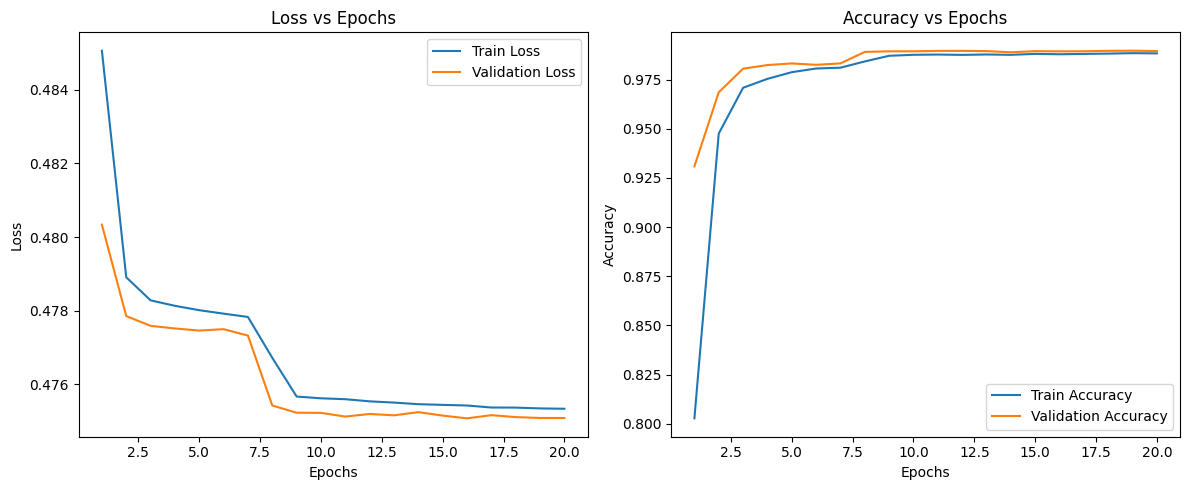

In [ ]:
# Plot Training and Validation Metrics

# Plot Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate the Test Set

In [ ]:
model.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():
    for categorical_data, numerical_data in test_loader:
        categorical_data = categorical_data.to(device)
        numerical_data = numerical_data.to(device)

        # Forward pass through the model
        outputs = model(categorical_data, numerical_data).squeeze()

        # Apply sigmoid and round to get binary predictions
        preds = torch.round(torch.sigmoid(outputs))

        # Collect predictions
        predictions.extend(preds.cpu().numpy())



In [ ]:
# Create the new DataFrame
result = pd.DataFrame({
    'id': df_test_id,
    'class': predictions
})

# Define the mapping dictionary
label_mapping = {0: 'e', 1: 'p'}

# Apply the mapping to the 'class' column
result['class'] = result['class'].map(label_mapping)

# Display the updated DataFrame
result

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [ ]:
# Save the Mapped Results to a File
result.to_csv('submission.csv', index=False)

### **Updated Model with 1D CNN:**
I updated my `MushroomNet` architecture to use a **1D Convolutional Neural Network (CNN)**.

A **1D CNN** is appropriate since the inputs are structured as a sequence (e.g., numerical features concatenated with embeddings).

### Key Changes:
1. **Convolutional Layers:**
   - Added two 1D convolutional layers (`conv1` and `conv2`) with appropriate padding and kernel sizes.
   - Applied `MaxPool1d` after each convolution to reduce the sequence dimension progressively.

2. **Global Average Pooling:**
   - Used `.mean(dim=2)` to reduce the output of the second convolution layer to a fixed-size representation (`batch_size, 32`).

3. **Concatenation:**
   - Concatenated the CNN features with the numerical features before passing them to fully connected layers.

4. **Fully Connected Layers:**
   - The dense layers (`fc1`, `fc2`, `fc3`) remain to produce the binary classification output.

---

### Explanation of CNN Architecture:
- **1D Convolution:**
  - Treats the embedding representation as a sequence, where each embedding vector represents a "feature" in the sequence.

- **MaxPooling:**
  - Reduces the sequence length while retaining the most important features.

- **Global Average Pooling:**
  - Compresses the sequence dimension into a fixed vector by averaging across it, making the output compatible with the fully connected layers.

---

This **CNN-based** approach will let us compare its performance with our fully connected network.

In [ ]:
class MushroomCNN(nn.Module):
    def __init__(self, embedding_sizes, num_numerical_features):
        super(MushroomCNN, self).__init__()

        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, size) for categories, size in embedding_sizes
        ])

        # Dimensions after embedding concatenation
        embedding_dim = sum([size for _, size in embedding_sizes])

        # Convolutional layers
        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=16, kernel_size=3, padding=1  # 1D Convolution
        )
        self.conv2 = nn.Conv1d(
            in_channels=16, out_channels=32, kernel_size=3, padding=1
        )

        # Fully connected layers
        self.fc1 = nn.Linear(32 + num_numerical_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer (binary classification)

        # Activation, pooling, and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

    def forward(self, categorical_inputs, numerical_inputs):
        # Process embeddings
        embeddings = [embedding(categorical_inputs[:, i]) for i, embedding in enumerate(self.embeddings)]
        embeddings = torch.cat(embeddings, dim=1)  # Shape: (batch_size, embedding_dim)

        # Add a channel dimension for convolution
        embeddings = embeddings.unsqueeze(1)  # Shape: (batch_size, 1, embedding_dim)

        # Forward pass through convolutional layers
        x = self.relu(self.conv1(embeddings))  # Shape: (batch_size, 16, embedding_dim)
        x = self.maxpool(x)  # Shape: (batch_size, 16, embedding_dim//2)
        x = self.relu(self.conv2(x))  # Shape: (batch_size, 32, embedding_dim//2)
        x = self.maxpool(x)  # Shape: (batch_size, 32, embedding_dim//4)

        # Global average pooling (reduce across sequence dimension)
        x = x.mean(dim=2)  # Shape: (batch_size, 32)

        # Concatenate numerical features
        x = torch.cat([x, numerical_inputs], dim=1)  # Shape: (batch_size, 32 + num_numerical_features)

        # Forward pass through dense layers
        x = self.dropout(self.relu(self.fc1(x)))  # Shape: (batch_size, 64)
        x = self.dropout(self.relu(self.fc2(x)))  # Shape: (batch_size, 32)
        # x = self.sigmoid(self.fc3(x))  # For BCELoss
        x = self.fc3(x)  # For BCEWithLogitsLoss
        return x


In [ ]:
# Instantiate the Model
embedding_sizes = [(len(df_train[col].unique()), min(50, (len(df_train[col].unique()) + 1) // 2)) for col in cat_columns]
num_numerical_features = len(num_columns)

model = MushroomCNN(embedding_sizes, num_numerical_features).to(device)


In [ ]:
# Define the Loss Function and Optimizer
# criterion = nn.BCELoss(weight=class_weights)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print(model)

MushroomCNN(
  (embeddings): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(14, 7)
    (2): Embedding(13, 7)
    (3): Embedding(3, 2)
    (4): Embedding(9, 5)
    (5): Embedding(4, 2)
    (6): Embedding(13, 7)
    (7): Embedding(6, 3)
    (8): Embedding(9, 5)
    (9): Embedding(14, 7)
    (10): Embedding(2, 1)
    (11): Embedding(7, 4)
    (12): Embedding(3, 2)
    (13): Embedding(10, 5)
    (14): Embedding(8, 4)
    (15): Embedding(9, 5)
    (16): Embedding(4, 2)
  )
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=35, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
%%time
# Initialize lists to store train metrics
train_losses = []
train_accuracies = []

# Initialize lists to store validation metrics
valid_losses = []
valid_accuracies = []

epochs = 20

# Train the Model
for epoch in range(epochs):
    # Training Phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for categorical_data, numerical_data, targets in train_loader:
        # Move data to device
        categorical_data = categorical_data.to(device).long()  # Ensure integer type
        numerical_data = numerical_data.to(device)
        targets = targets.to(device).float()  # Targets as floats for BCEWithLogitsLoss

        # Forward pass
        optimizer.zero_grad()
        outputs = model(categorical_data, numerical_data).squeeze()
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        epoch_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for categorical_data, numerical_data, targets in valid_loader:
            # Move data to device
            categorical_data = categorical_data.to(device).long()
            numerical_data = numerical_data.to(device)
            targets = targets.to(device).float()

            # Forward pass
            outputs = model(categorical_data, numerical_data).squeeze()
            loss = criterion(outputs, targets)

            # Accumulate validation loss and accuracy
            valid_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))  # Sigmoid + Thresholding
            valid_correct += (predictions == targets).sum().item()
            valid_total += targets.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct / valid_total
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")


Epoch 1/20, Train Loss: 0.1377, Train Accuracy: 0.9504, Validation Loss: 0.0641, Validation Accuracy: 0.9830
Epoch 2/20, Train Loss: 0.0719, Train Accuracy: 0.9814, Validation Loss: 0.0580, Validation Accuracy: 0.9846
Epoch 3/20, Train Loss: 0.0642, Train Accuracy: 0.9838, Validation Loss: 0.0522, Validation Accuracy: 0.9861
Epoch 4/20, Train Loss: 0.0604, Train Accuracy: 0.9850, Validation Loss: 0.0488, Validation Accuracy: 0.9873
Epoch 5/20, Train Loss: 0.0581, Train Accuracy: 0.9857, Validation Loss: 0.0483, Validation Accuracy: 0.9877
Epoch 6/20, Train Loss: 0.0567, Train Accuracy: 0.9861, Validation Loss: 0.0486, Validation Accuracy: 0.9876
Epoch 7/20, Train Loss: 0.0554, Train Accuracy: 0.9865, Validation Loss: 0.0459, Validation Accuracy: 0.9883
Epoch 8/20, Train Loss: 0.0544, Train Accuracy: 0.9867, Validation Loss: 0.0454, Validation Accuracy: 0.9884
Epoch 9/20, Train Loss: 0.0537, Train Accuracy: 0.9869, Validation Loss: 0.0449, Validation Accuracy: 0.9888
Epoch 10/20, Train 

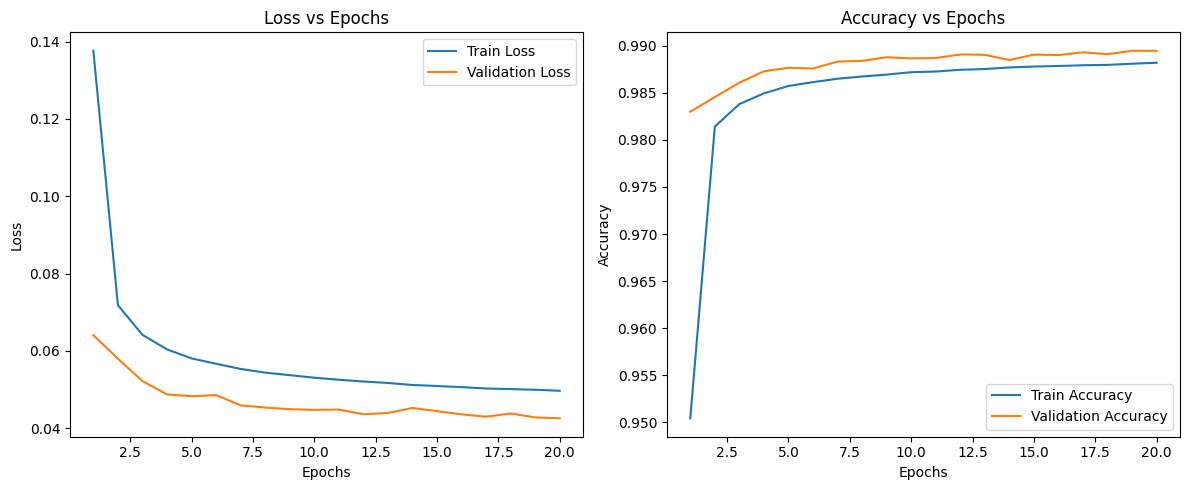

In [ ]:
# Plot Training and Validation Metrics

# Plot Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():
    for categorical_data, numerical_data in test_loader:
        categorical_data = categorical_data.to(device)
        numerical_data = numerical_data.to(device)

        # Forward pass through the model
        outputs = model(categorical_data, numerical_data).squeeze()

        # Apply sigmoid and round to get binary predictions
        preds = torch.round(torch.sigmoid(outputs))

        # Collect predictions
        predictions.extend(preds.cpu().numpy())



In [ ]:
# Create the new DataFrame
result_2 = pd.DataFrame({
    'id': df_test_id,
    'class': predictions
})

# Define the mapping dictionary
label_mapping = {0: 'e', 1: 'p'}

# Apply the mapping to the 'class' column
result_2['class'] = result_2['class'].map(label_mapping)

# Display the updated DataFrame
result_2

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
